In [1]:
pip list

Package                       Version
----------------------------- -----------
absl-py                       1.4.0
alabaster                     0.7.12
anyio                         3.5.0
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.3
astroid                       2.11.7
asttokens                     2.0.5
astunparse                    1.6.3
atomicwrites                  1.4.0
attrs                         22.1.0
autopep8                      1.6.0
Babel                         2.11.0
backcall                      0.2.0
bcrypt                        3.2.0
beautifulsoup4                4.11.1
binaryornot                   0.4.4
black                         22.6.0
bleach                        4.1.0
brotlipy                      0.7.0
cachetools                    5.3.0
certifi                       2022.12.7
cffi                          1.15.1
chardet                       4.0.0
charset-normalizer            3.0.1
click  

In [2]:
import tensorflow as tf
import os

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
tf.config.list_physical_devices('CPU')

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

# 2. Remove dodgy images

In [6]:
import cv2
import imghdr

In [7]:
data_dir = 'data'

In [8]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [9]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [10]:
import numpy as np
from matplotlib import pyplot as plt

In [11]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 305 files belonging to 2 classes.


In [12]:
data_iterator = data.as_numpy_iterator()

In [13]:
batch = data_iterator.next()

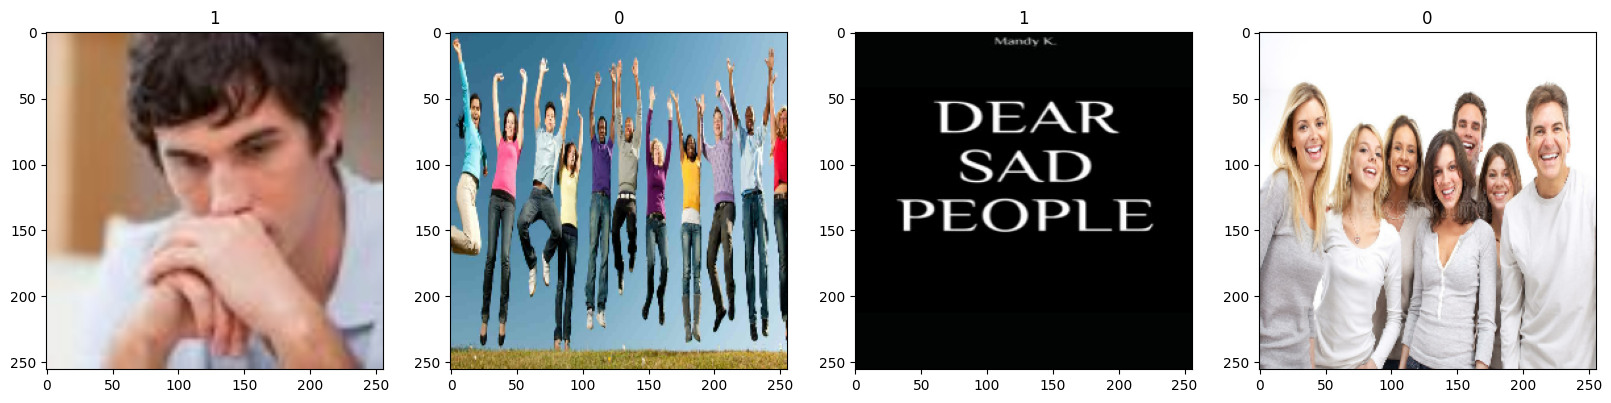

In [14]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [15]:
data = data.map(lambda x,y: (x/255, y))

In [16]:
data.as_numpy_iterator().next()

(array([[[[0.1799326 , 0.7448836 , 0.7682292 ],
          [0.1799326 , 0.7448836 , 0.7682292 ],
          [0.1799326 , 0.7448836 , 0.7682292 ],
          ...,
          [0.1799326 , 0.7448836 , 0.7682292 ],
          [0.1799326 , 0.7448836 , 0.7682292 ],
          [0.1799326 , 0.7448836 , 0.7682292 ]],
 
         [[0.05882353, 0.7058824 , 0.73333335],
          [0.05882353, 0.7058824 , 0.73333335],
          [0.05882353, 0.7058824 , 0.73333335],
          ...,
          [0.05882353, 0.7058824 , 0.73333335],
          [0.05882353, 0.7058824 , 0.73333335],
          [0.05882353, 0.7058824 , 0.73333335]],
 
         [[0.05882353, 0.7058824 , 0.73333335],
          [0.05882353, 0.7058824 , 0.73333335],
          [0.05882353, 0.7058824 , 0.73333335],
          ...,
          [0.05882353, 0.7058824 , 0.73333335],
          [0.05882353, 0.7058824 , 0.73333335],
          [0.05882353, 0.7058824 , 0.73333335]],
 
         ...,
 
         [[0.05882353, 0.7058824 , 0.73333335],
          [0.05882

# 5. Split Data

In [17]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [18]:
train_size

7

In [19]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [20]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [22]:
model = Sequential()

In [23]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [24]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

# 7. Train

In [26]:
logdir='logs'

In [27]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 [==============================] - 22s 839ms/step - loss: 0.9068 - accuracy: 0.4777 - val_loss: 0.6971 - val_accuracy: 0.5156
Epoch 2/20
7/7 [==============================] - 9s 772ms/step - loss: 0.6896 - accuracy: 0.5938 - val_loss: 0.6688 - val_accuracy: 0.6094
Epoch 3/20
7/7 [==============================] - 9s 750ms/step - loss: 0.6502 - accuracy: 0.5982 - val_loss: 0.6101 - val_accuracy: 0.7812
Epoch 4/20
7/7 [==============================] - 9s 781ms/step - loss: 0.5748 - accuracy: 0.7411 - val_loss: 0.6055 - val_accuracy: 0.7344
Epoch 5/20
7/7 [==============================] - 9s 774ms/step - loss: 0.5219 - accuracy: 0.7500 - val_loss: 0.4545 - val_accuracy: 0.8125
Epoch 6/20
7/7 [==============================] - 9s 767ms/step - loss: 0.4231 - accuracy: 0.8393 - val_loss: 0.3041 - val_accuracy: 0.9219
Epoch 7/20
7/7 [==============================] - 9s 750ms/step - loss: 0.2882 - accuracy: 0.8973 - val_loss: 0.3459 - val_accuracy: 0.8594
Epoch 8/20
7/7 [===

# 8. Plot Performance

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

In [ ]:
print(pre.result(), re.result(), acc.result())

# 10. Test

In [ ]:
import cv2

In [ ]:
img = cv2.imread('happy.jpg')
plt.imshow(img)
plt.show()

In [ ]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [ ]:
yhat = model.predict(np.expand_dims(resize/255, 0))

In [ ]:
yhat

In [ ]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

# 11. Save the Model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model.save(os.path.join('models','imageclassifier.h5'))

In [ ]:
new_model = load_model('models\imageclassifier.h5')

In [ ]:
new_model.predict(np.expand_dims(resize/255, 0))